# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [40]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# for dataframe display
pd.set_option("display.max_rows", None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of answers
keras.utils.set_random_seed(42)


In [41]:
# Download Sample Data AAPL_2009_4m_training_features_1d (cleaned, not normalized, with features)
data = pd.read_csv('AAPL_2009_4m_training_features_1d.csv')
# track index to remember which feature is which
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

# 2. Train / Test Split
Now that we have loaded our cleaned price dataset, we are ready to feed the data into our model. With this in mind, we select Close as our singular training feature, and split the data ito train and test data (80/20 split)

In [42]:
# split dataset df into train (80%) and test (20%) datasets
training_rows = int(len(data) * 0.8)
train_df = data.iloc[:training_rows].set_index("Date")
test_df = data.iloc[training_rows:].set_index("Date")

In [43]:
# display train and test dfs (ensure no overlap)
display_df(train_df)
display_df(test_df)

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,4.493929,4.576559,4.040905
2009-05-01,4.544286,4.587013,4.082345
2009-05-04,4.544286,4.606655,4.102880
2009-05-05,4.739643,4.677963,4.082501
2009-05-06,4.732143,4.732943,4.077699
2009-05-07,4.609286,4.745322,4.110821
2009-05-08,4.613929,4.763748,4.126752
2009-05-11,4.627500,4.781972,4.141921
2009-05-12,4.627500,4.789788,4.174320


,Close,BB_upper,BB_lower
Date,,,
2009-06-18,4.852857,5.315920,4.459259
2009-06-19,4.981429,5.287810,4.542011
2009-06-22,4.906071,5.214837,4.668092
2009-06-23,4.786071,5.200695,4.693770
2009-06-24,4.786071,5.197255,4.700638
2009-06-25,4.995000,5.199378,4.715622
2009-06-26,5.087143,5.210573,4.730748
2009-06-29,5.070357,5.219369,4.731310
2009-06-30,5.086786,5.229668,4.731510


In [54]:
# --- THE FIX: Define indices AFTER the DataFrame is finalized ---
# By defining the indices on train_df, they will match the structure of X_train.
idx_close = train_df.columns.get_loc('Close')        # Correctly returns 0
idx_bb_upper = train_df.columns.get_loc('BB_upper')  # Correctly returns 1
idx_bb_lower = train_df.columns.get_loc('BB_lower')  # Correctly returns 2

In [55]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (34, 3)
Testing data shape: (9, 3)


# 3. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this excercise, we are creating a sequential model with three layers. The first two layers have output shape of 32 and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss function is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [56]:
@keras.saving.register_keras_serializable()
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        model = keras.Sequential([
            keras.Input(shape=(state_size,)),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(8, activation="relu"),
            keras.layers.Dense(action_size, activation="linear")
        ])        
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [57]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = window_size * num_features
        self.action_size = 3
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size), verbose=0)

    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    

    def act(self, state): 
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)   
        q_values = self.get_q_values_for_state(state)
        return np.argmax(q_values[0]) 

    def exp_replay(self, batch_size):
        if len(self.memory) < batch_size:
            return []
        mini_batch = random.sample(self.memory, batch_size)
        losses = []
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                future_q_values = self.get_q_values_for_state(next_state)
                target = reward + self.gamma * np.amax(future_q_values[0])
            target_q_table = self.get_q_values_for_state(state)  
            target_q_table[0][action] = target
            history = self.fit_model(state, target_q_table)
            losses.extend(history.history['loss'])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

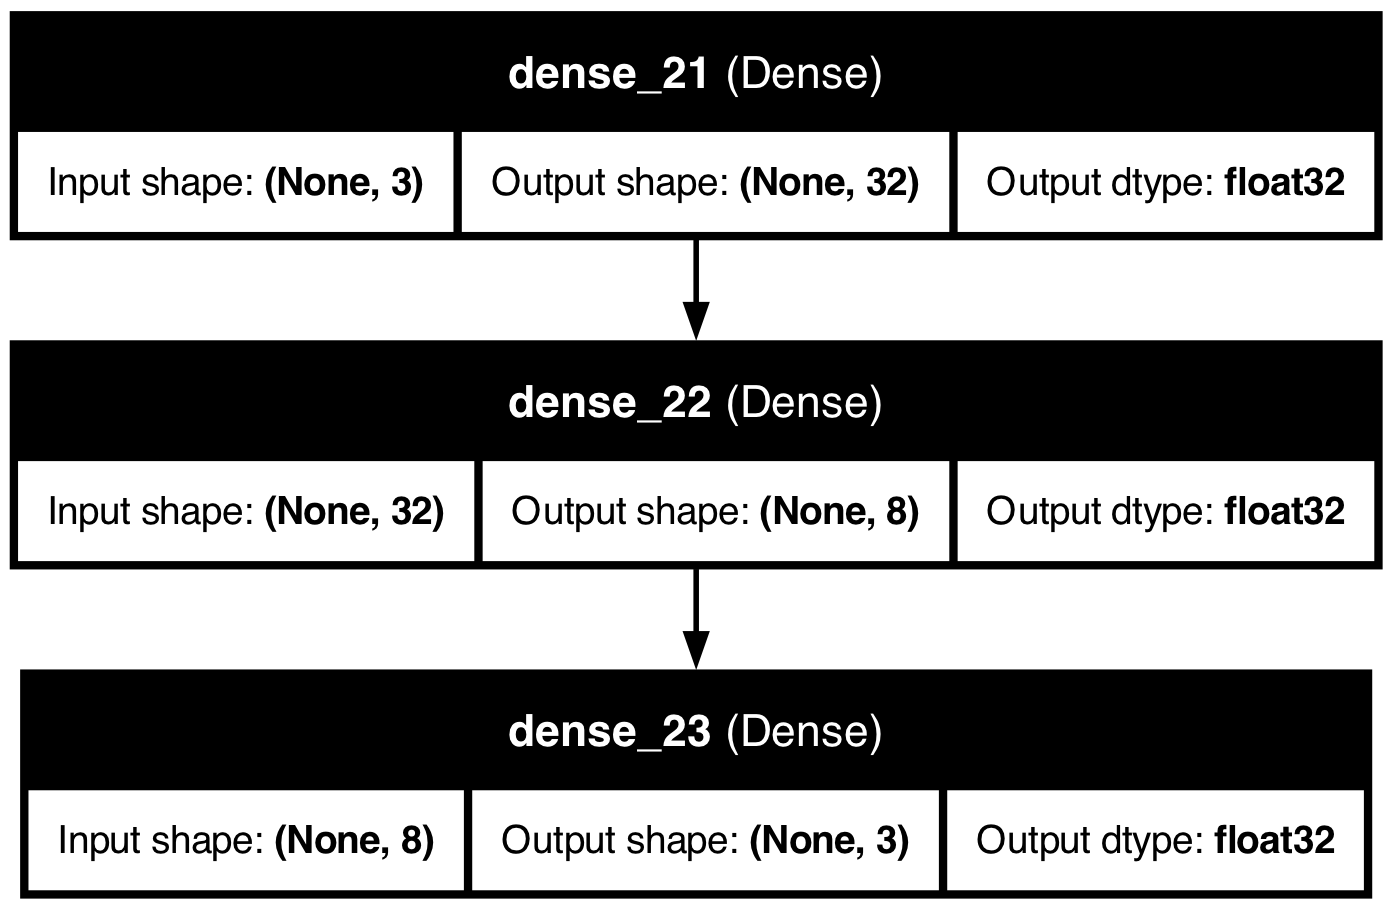

In [58]:
keras.utils.disable_interactive_logging()
from tqdm.notebook import tqdm

# Initialize agent
window_size = 1
agent = Agent(window_size, num_features=X_train.shape[1])

dot = keras.utils.model_to_dot(
    agent.model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)
dot.write("model.png", format='png')
from IPython import display

display.Image('model.png')

# 4. Train the Agent
Now that our agent is defined, we are ready to train it. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoind funtion, one to grab the state representation, and one to plot the output of our trained model. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [59]:
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

sigmoid = np.vectorize(lambda x: 1 / (1 + math.exp(-x)))

def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='g', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='r', label = 'Selling signal', markevery = states_sell)
    plt.title(f'Total gains: {format_price(profit)}')
    plt.legend()
    # (Plotting code for x-ticks remains the same)
    plt.show()

def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('Batch Number')
    plt.show()

def get_state(data, t, n):
    start = t - n + 1
    end = t + 1
    if start < 0:
        padding = np.tile(data[0], (abs(start), 1))
        actual_data = data[0:end]
        block = np.vstack((padding, actual_data))
    else:
        block = data[start:end]
    res = sigmoid(block)
    return res

### Training Loop

In [60]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
X_train.shape

(34, 3)


--- Starting Episode: 1/2 ---


Running episode 1/2:   0%|          | 0/33 [00:00<?, ?it/s]

--------------------------------
Episode 1 Summary
Total Profit: $3.29
--------------------------------


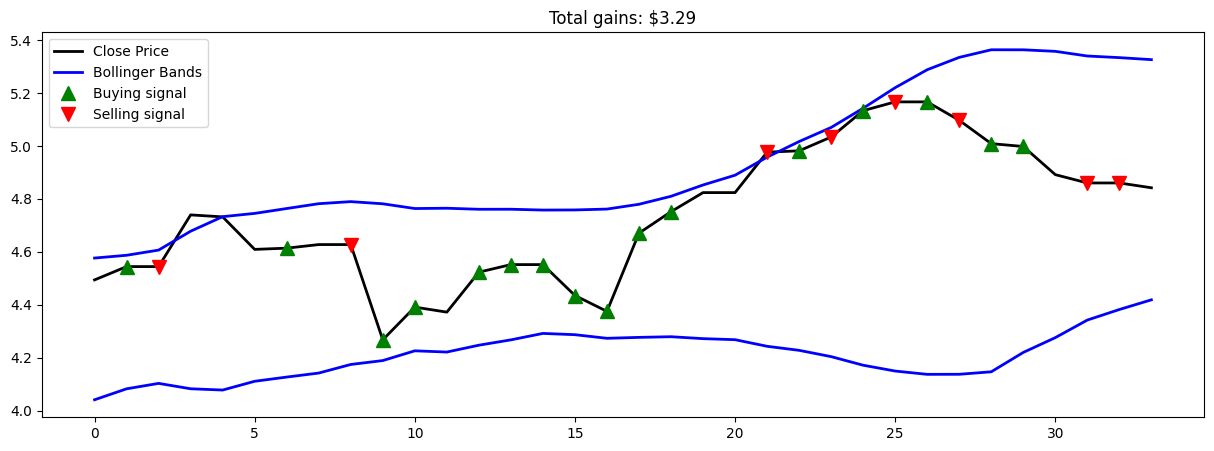

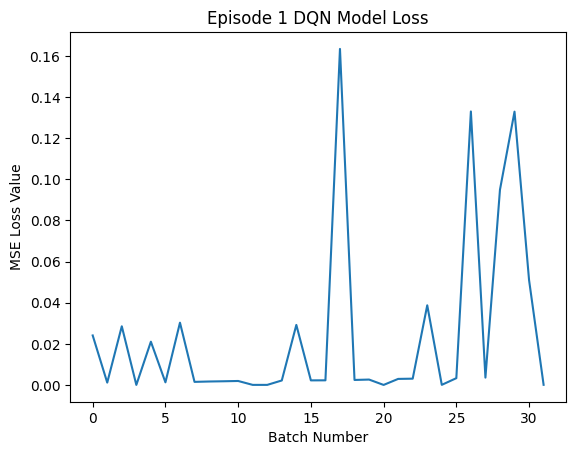


--- Starting Episode: 2/2 ---


Running episode 2/2:   0%|          | 0/33 [00:00<?, ?it/s]

--------------------------------
Episode 2 Summary
Total Profit: $1.55
--------------------------------


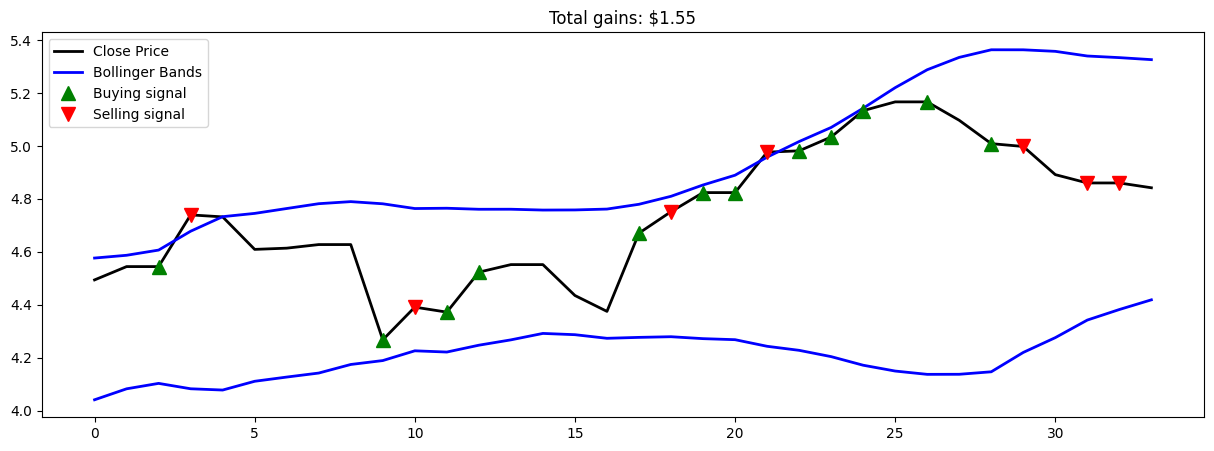

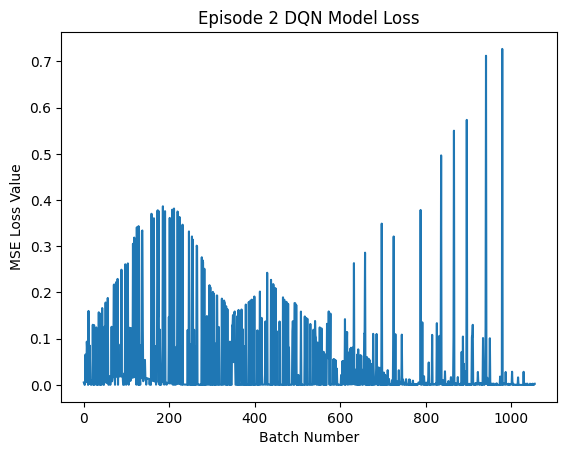

In [61]:
keras.config.disable_traceback_filtering()
l = len(X_train) - 1
batch_size = 32
episode_count = 2

batch_losses = []
total_episodes_trained = 0

for e in range(episode_count):
    print(f"\n--- Starting Episode: {e+1}/{episode_count} ---")
    state = get_state(X_train, 0, window_size)
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l), desc=f'Running episode {e+1}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size)
        reward = 0

        if action == 1: # Buy
            agent.inventory.append(X_train[t, idx_close])
            states_buy.append(t)
        elif action == 2 and len(agent.inventory) > 0: # Sell
            bought_price = agent.inventory.pop(0)
            sell_price = X_train[t, idx_close]
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            states_sell.append(t)

        done = t == l - 1
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(agent.memory) > batch_size:
            losses_for_batch = agent.exp_replay(batch_size)
            batch_losses.extend(losses_for_batch)

    print(f'--------------------------------\nEpisode {e+1} Summary\nTotal Profit: {format_price(total_profit)}\n--------------------------------')
    plot_behavior(X_train[:, idx_close], X_train[:, idx_bb_upper], X_train[:, idx_bb_lower], states_buy, states_sell, total_profit)
    plot_losses(batch_losses[total_episodes_trained:], f'Episode {e+1} DQN Model Loss')
    total_episodes_trained = len(batch_losses)
    agent.model.save(f'model_ep{e+1}.keras')


### Plot Training Loss

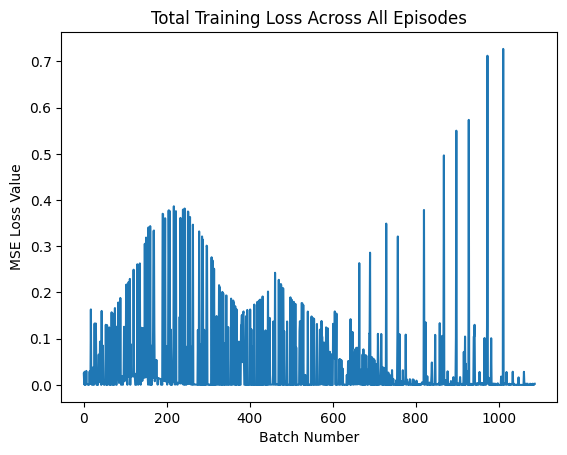

In [62]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "Total Training Loss Across All Episodes")

# 5. Test the trained model 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

## Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [63]:
l_test = len(X_test) - 1
total_profit = 0
states_sell_test = []
states_buy_test = []

# Load the final trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

# Get the first state of the test dataset
state = get_state(X_test, 0, window_size)

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Running Test:   0%|          | 0/8 [00:00<?, ?it/s]

------------------------------------------
Total Test Profit: $0.00
------------------------------------------


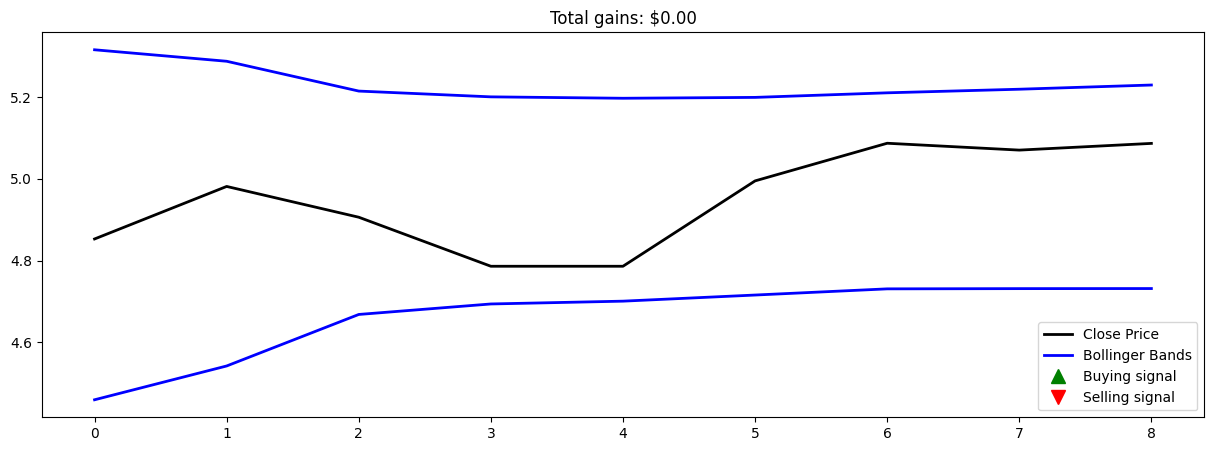

In [64]:
l_test = len(X_test) - 1
total_profit = 0
states_sell_test = []
states_buy_test = []

agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []
state = get_state(X_test, 0, window_size)

for t in tqdm(range(l_test), desc="Running Test"):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size)

    if action == 1: # Buy
        buy_price = X_test[t, idx_close]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
    elif action == 2 and len(agent.inventory) > 0: # Sell
        bought_price = agent.inventory.pop(0)
        sell_price = X_test[t, idx_close]
        trade_profit = sell_price - bought_price
        total_profit += trade_profit
        states_sell_test.append(t)

    state = next_state

print('------------------------------------------')
print(f'Total Test Profit: {format_price(total_profit)}')
print('------------------------------------------')

plot_behavior(X_test[:, idx_close], X_test[:, idx_bb_upper], X_test[:, idx_bb_lower], states_buy_test, states_sell_test, total_profit, train=False)